<a href="https://colab.research.google.com/github/cakennedy/266-mbti-project/blob/main/MBTI_Base_Cases_And_Experiments_1026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W266 Final Project
# Model Building
# October 22, 2022
# John Clark, Shrinivas Joshi, Courtney Kennedy


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cakennedy/266-mbti-project/blob/main/notebooks/MBTI_Base_Cases_And_Experiments.ipynb#)

In [ ]:
# Import libraries
!pip install transformers
from google.colab import files
from google.cloud import storage
import pandas as pd
import io
from io import BytesIO
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
import textwrap
import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sys
import csv
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# These auto classes load the right type of tokenizer and model based on a model name
from transformers import AutoTokenizer, TFAutoModel
from transformers import BertTokenizer, TFBertModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.6 MB/s 
     |████████████████████████████████| 7.6 MB 74.2 MB/s 
     |████████████████████████████████| 163 kB 90.9 MB/s 


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


##Load Files

The first step in this notebook is the load the train, dev and test files files created by PredictPersonality_Type_1018.ipynb. 

In [ ]:
#Manually upload JSON file for authentication
uploaded = files.upload()

Saving pacific-castle-360400-a3ca89f64de6.json to pacific-castle-360400-a3ca89f64de6.json


In [ ]:
#utility for reading csv file from shared Google Cloud storage
def read_csv_file( filename,
                    encoding='utf-8',
                    separator=',' ):
    '''This function reads a file from the google cloud storage bucket. Input
    parameters include the filename, encoding and CSV file separators.'''

    #Grab blob posts file and download as string
    blobby = bucket.blob(filename)
    blobby_string = blobby.download_as_string()

    #Convert to pandas
    df = pd.read_csv(io.BytesIO(blobby_string), encoding=encoding, \
                     sep=separator, engine='python')
   
    return df

In [ ]:
# Google collab premium utilities status check
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print( '\n')

# RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Wed Oct 26 20:38:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    42W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

#Initialize google storage
storage_client = storage.Client.from_service_account_json('pacific-castle-360400-a3ca89f64de6.json')

#Print buckets available
for bucket in storage_client.list_buckets():
  print(bucket)

#Assign bucket name being used
bucket_name = '266csffile'

#Get bucket
bucket = storage_client.get_bucket(bucket_name)

#Show list of files in bucket and list the files
filelist = list(bucket.list_blobs(prefix=''))
for name in filelist:
  print(name.name)


<Bucket: 266csffile>
dev_mbti_data.csv
dev_mbti_data.parquet
dev_mbti_labels.csv
test_mbti_data.csv
test_mbti_data.parquet
test_mbti_labels.csv
train_gen_pop_mbti_data.csv
train_gen_pop_mbti_data.parquet
train_gen_pop_mbti_labels.csv
train_mbti_data.csv
train_mbti_data.parquet
train_mbti_labels.csv
train_over_sampled_mbti_data.csv
train_over_sampled_mbti_data.parquet
train_over_sampled_mbti_labels.csv
train_under_sampled_mbti_data.csv
train_under_sampled_mbti_data.parquet
train_under_sampled_mbti_labels.csv
typology_merged.parquet
typology_users_clean.csv
typology_xenforo-9-25-22-posts.csv
typology_xenforo-9-25-22.csv
typology_xenforo-9-25-22_clean.parquet


In [ ]:

def read_parquet_google_cloud(file):
    '''This function reads a file from the google cloud storage bucket. Input
    parameters include the filename, encoding and CSV file separators.'''

    #Load Google Cloud storage client using service key

    blob = bucket.blob(file)
    read_back = bucket.blob(file)
    string_read_back = read_back.download_as_string()
    new_df = pd.read_parquet(io.BytesIO(string_read_back))

    return new_df

#    blob.upload_from_string(df.to_parquet(), 'application/octet-stream')

In [ ]:
#Read in train, dev and test files
train_mbti_data = read_parquet_google_cloud('train_mbti_data.parquet')
train_mbti_labels = read_csv_file('train_mbti_labels.csv')
test_mbti_data = read_parquet_google_cloud('test_mbti_data.parquet')
test_mbti_labels = read_csv_file('test_mbti_labels.csv')
dev_mbti_data = read_parquet_google_cloud('dev_mbti_data.parquet')
dev_mbti_labels = read_csv_file('dev_mbti_labels.csv')


In [ ]:
print('train shape', train_mbti_data.shape)
print('dev shape', dev_mbti_data.shape)
print('test shape', test_mbti_data.shape)
print('train labels shape', train_mbti_labels.shape)
print('dev labels shape', dev_mbti_labels.shape)
print('test labels shape', test_mbti_labels.shape)

train shape (1200000, 15)
dev shape (200000, 15)
test shape (200000, 15)
train labels shape (1200000, 2)
dev labels shape (200000, 2)
test labels shape (200000, 2)


In [ ]:
train_mbti_labels[:600]

,Unnamed: 0,MBTI Type
0,0,ENTP
1,1,ENTP
2,2,ENTP
3,3,INFJ
4,4,INFJ
...,...,...
595,595,INFJ
596,596,INFJ
597,597,INFJ
598,598,INFJ


In [ ]:
#Increase field size to allow reading in of input files

maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 as long as overflow error occurs 
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

In [ ]:
print(train_mbti_data.head() )

null_data = train_mbti_data.isnull().sum()
print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Train dataset')
null_data = dev_mbti_data.isnull().sum()
print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Dev dataset')
null_data = test_mbti_data.isnull().sum()
print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Test dataset')

    Username   Age  Posts Enneagram Instinctual Variant  Gender Occupation  \
0  (FL)Cross  31.0      3      None                None    None       None   
1  (FL)Cross  31.0      3      None                None    None       None   
2  (FL)Cross  31.0      3      None                None    None       None   
3  *avariel*  37.0     21       145               so_sp  female       None   
4  *avariel*  37.0     21       145               so_sp  female       None   

    is_I   is_S   is_T   is_J  post_id  thread_id   post_date  \
0  False  False   True  False  1087131      28751  1268893290   
1  False  False   True  False  1087167      28480  1268894726   
2  False  False   True  False  1087226      28924  1268899561   
3   True  False  False   True  2377882      51955  1414832242   
4   True  False  False   True  2377914      73107  1414842094   

                                             message  
0    ooh ooh ooh, how about listing bad pick up l...  
1  how can you tell if an XXXX

In [ ]:
print(' There are', '{:,}'.format(null_data['post_date']), 'Nan values the Train dataset')
null_data = test_mbti_data.isnull().sum()

 There are 0 Nan values the Train dataset


In [ ]:
null_data = train_mbti_data.isnull().sum()
print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Train dataset')
null_data = dev_mbti_data.isnull().sum()
print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Dev dataset')
null_data = test_mbti_data.isnull().sum()
print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Test dataset')

 There are 0 missing message rows in the Train dataset
 There are 0 missing message rows in the Dev dataset
 There are 0 missing message rows in the Test dataset


Tempory code to clean data

##Run Baseline Models 

These steps run a set of baseline models with a small subset of the input data. 

In [ ]:
#Set up small train, dev and test data and labels to do initial testing before chunking
train_data, train_labels = train_mbti_data[:60000], train_mbti_labels[:60000]
dev_data, dev_labels = dev_mbti_data[:10000], dev_mbti_labels[:10000]
test_data, test_labels = test_mbti_data[:10000], test_mbti_labels[:10000]

#Determine and print number of rows in each dataset
train_rows = train_data.shape[0]
dev_rows = dev_data.shape[0]
test_rows = test_data.shape[0]
total_records = train_rows+dev_rows+test_rows
print('After Data Split')
print(' TRAIN dataset row count: ', '{:,}'.format(train_rows))
print(' DEV dataset row count  : ', '{:,}'.format(dev_rows))
print(' TEST dataset row count : ', '{:,}'.format(test_rows))
print(' Total rows             : ', '{:,}'.format(total_records))
null_data = train_data.isnull().sum()
print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Train dataset')
null_data = dev_data.isnull().sum()
print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Dev dataset')
null_data = test_data.isnull().sum()
print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Test dataset')

After Data Split
 TRAIN dataset row count:  60,000
 DEV dataset row count  :  10,000
 TEST dataset row count :  10,000
 Total rows             :  80,000
 There are 0 missing message rows in the Train dataset
 There are 0 missing message rows in the Dev dataset
 There are 0 missing message rows in the Test dataset


In [ ]:
#Create dictonary to transform MBTI type into multiclass value from 0 to 15
valid_MBTI = {'ISTJ': 0, 'INTJ': 1, 'ESTJ': 2, 'ENTJ': 3, 'ENTP': 4, 'INTP': 5, \
              'ISTP': 6, 'ESTP': 7, 'ISFJ': 8, 'INFJ': 9, 'ESFJ': 10, \
              'ENFJ': 11, 'ENFP': 12, 'INFP': 13, 'ISFP': 14, 'ESFP': 15}


In [ ]:
#Set multiclass numerical value based on MBTI type
train_labels['class'] = train_labels['MBTI Type'].map(valid_MBTI)
test_labels['class'] = test_labels['MBTI Type'].map(valid_MBTI)
dev_labels['class'] = dev_labels['MBTI Type'].map(valid_MBTI)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
train_labels[:10]


,Unnamed: 0,MBTI Type,class
0,0,ENTP,4
1,1,ENTP,4
2,2,ENTP,4
3,3,INFJ,9
4,4,INFJ,9
5,5,INFJ,9
6,6,INFJ,9
7,7,INFJ,9
8,8,INFJ,9
9,9,INFJ,9


In [ ]:
#Transform data to matrices of word unigram features using preprocessing
num_words_a = 1
num_words_b = 1
vectorizer_t_preprocess = TfidfVectorizer(ngram_range=(num_words_a, num_words_b))
train_cv = vectorizer_t_preprocess.fit_transform(train_data["message"].values.astype('U')) 
train_features = vectorizer_t_preprocess.get_feature_names_out()
print('\ntrain_features', len(train_features))
vectorizer_d_nopreprocess = TfidfVectorizer(ngram_range=(num_words_a, num_words_b), vocabulary = train_features)
dev_cv = vectorizer_d_nopreprocess.fit_transform(dev_data["message"].values.astype('U')) 
dev_features = vectorizer_d_nopreprocess.get_feature_names_out()
print('dev features', len(dev_features))

#Print some statistics on the vectorization
print('\nPrinting statistics for preprocessed data:')
print('Vocabulary size = ', "{:,}".format(train_cv.shape[1]))
print('Number of non zero features = ', "{:,}".format(train_cv.nnz))
print('Number of samples in training dataset = ', "{:,}".format(train_cv.shape[0]))
print('Average non zero features per example = ', "{:,}".format(train_cv.nnz/train_cv.shape[0]))
total_entries = train_cv.shape[0] * train_cv.shape[1]
print('Fraction of non zero entries in the matrix = ', round((train_cv.nnz/total_entries), 6))
print('First feature = ', train_features[0], '  Last feature = ', train_features[len(train_features) - 1])


train_features 70047
dev features 70047

Printing statistics for preprocessed data:
Vocabulary size =  70,047
Number of non zero features =  2,427,729
Number of samples in training dataset =  60,000
Average non zero features per example =  40.46215
Fraction of non zero entries in the matrix =  0.000578
First feature =  00   Last feature =  zzlh0dyyywfpi


In [ ]:
#Logistic Regression using tfid vectorized data, no preprocessing, searching for best C value
for i in ([40,10,1, 0.001, .1, 0.01,0.0001]): 
  lr_model = LogisticRegression(C=i , solver='lbfgs' , max_iter = 300)
  lr_model.fit(train_cv, train_labels['class'])  #Attempt ravel to provide distinct labels
  predicted_labels = lr_model.predict(dev_cv)
  #Print results for predictions with dev dataset
  print('\033[1m\nLogistic Regression using unigram features with default vectorization\033[0m\n')
  print('F1 Score for c=', i,  str(metrics.f1_score(dev_labels['class'],predicted_labels, average='weighted')))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



Logistic Regression using unigram features with default vectorization

F1 Score for c= 40 0.1266525747371334


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



Logistic Regression using unigram features with default vectorization

F1 Score for c= 10 0.11889618760496547


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



Logistic Regression using unigram features with default vectorization

F1 Score for c= 1 0.08365840515748334

Logistic Regression using unigram features with default vectorization

F1 Score for c= 0.001 2.8765481422293243e-06

Logistic Regression using unigram features with default vectorization

F1 Score for c= 0.1 0.03230150946868648

Logistic Regression using unigram features with default vectorization

F1 Score for c= 0.01 0.0004026572822615691

Logistic Regression using unigram features with default vectorization

F1 Score for c= 0.0001 2.8765481422293243e-06


In [ ]:
print(dev_labels)

      Unnamed: 0 MBTI Type  class
0        1200000      INTP      5
1        1200001      INTP      5
2        1200002      INTP      5
3        1200003      INTP      5
4        1200004      INTP      5
...          ...       ...    ...
9995     1209995      ENTP      4
9996     1209996      ENTP      4
9997     1209997      ENTP      4
9998     1209998      ENTP      4
9999     1209999      ENTP      4

[10000 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


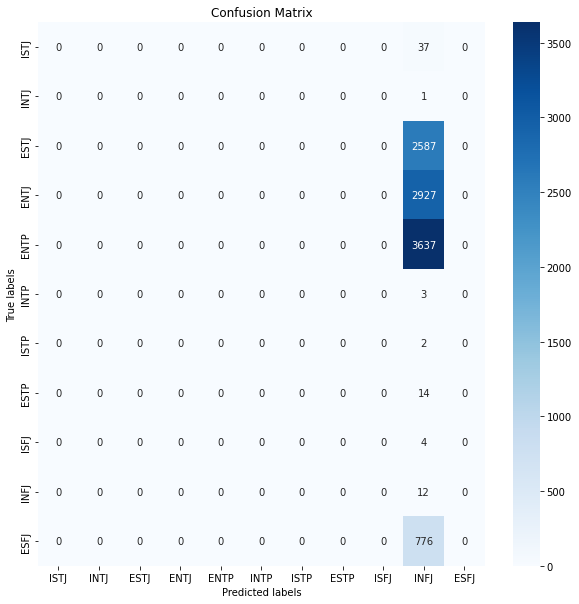

In [ ]:
#Visual Confusion Matrix
LR_Count = accuracy_score(predicted_labels, dev_labels['class'])
LR_Count_CM = classification_report(predicted_labels, dev_labels['class']) 

LR_Count_Confusion = confusion_matrix(dev_labels['class'], predicted_labels)

import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))      
sns.heatmap(LR_Count_Confusion, cmap="Blues", annot=True, fmt='d', ) # for decimal

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['ISTJ', 'INTJ', 'ESTJ', 'ENTJ', 'ENTP', 'INTP', 'ISTP', \
                         'ESTP', 'ISFJ', 'INFJ', 'ESFJ', 'ENFJ', 'ENFP', 'INFP', \
                         'ISFP', 'ESFP']); 
ax.yaxis.set_ticklabels(['ISTJ', \
                         'INTJ', 'ESTJ', 'ENTJ', 'ENTP', 'INTP', 'ISTP', \
                         'ESTP', 'ISFJ', 'INFJ', 'ESFJ', 'ENFJ', 'ENFP', 'INFP', \
                         'ISFP', 'ESFP']);
plt.show()

In [ ]:
#Set values of C
param_grid = {'C': [0.1,1, 3, 5, 10]}

#Conduct grid search for best C value
grid = GridSearchCV(LinearSVC(),param_grid,refit=True,verbose=1)
grid.fit(train_cv,train_labels['class'])

#Print best value of C
print('\nBest C value for LinearSVC:', grid.best_estimator_)

#Predict labels
predicted_labels = grid.predict(dev_cv)

#Print results for predictions with dev dataset
print('\033[1m\nLinear SVC using Text word counts\033[0m\n')
print('F1 Score : ' + str(metrics.f1_score(dev_labels['class'],predicted_labels, average='weighted')))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,



Best C value for LinearSVC: LinearSVC(C=0.1)

Linear SVC using Text word counts

F1 Score : 0.07952466683441253


In [ ]:
#get the labels in a needed data format for validation
npdev_labels = np.asarray(dev_labels['class'])
nptrain_labels = np.asarray(train_labels['class'])
nptest_labels = np.asarray(test_labels['class'])

In [ ]:
#Run simple base case BERT model
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)
max_length = 500


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
train_data_st = train_data['message'].values.tolist()
dev_data_st = dev_data['message'].values.tolist()
test_data_st = test_data['message'].values.tolist()

In [ ]:
null_data = train_data.isnull().sum()
print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Train dataset') 


 There are 0 missing message rows in the Train dataset


In [ ]:
null_data = test_data.isnull().sum()
print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Test dataset') 


 There are 0 missing message rows in the Test dataset


In [ ]:
null_data = dev_data.isnull().sum()
print(' There are', '{:,}'.format(null_data['message']), 'missing message rows in the Dev dataset') 

 There are 0 missing message rows in the Dev dataset


In [ ]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(train_data_st, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(dev_data_st, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_data_st, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [ ]:
# Extract encoded features and labels, add to corresponding lists
input_ids = np.array(train_encodings["input_ids"], dtype="int32")
attention_masks = np.array(train_encodings["attention_mask"], dtype="int32")
token_type_ids = np.array(train_encodings["token_type_ids"], dtype="int32")

attention_masks.shape

(60000, 500)

In [ ]:
train_encodings.input_ids[:5]

<tf.Tensor: shape=(5, 500), dtype=int32, numpy=
array([[  101,   184, 10559, ...,     0,     0,     0],
       [  101,  1293,  1169, ...,     0,     0,     0],
       [  101,  1725,  1202, ...,     0,     0,     0],
       [  101,  1119, 12821, ...,     0,     0,     0],
       [  101,   164,  2394, ...,     0,     0,     0]], dtype=int32)>

In [ ]:
def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                hidden_size = 201, 
                                dropout=0.3,
                                learning_rate=0.00005,
                                train_layers=-1):

  """
  Build a simple classification model with BERT. Use the Pooled Output for classification purposes.
    
  """

  input_ids = layers.Input(shape=(max_length), dtype=tf.int32, name='input_ids')
  attention_masks = layers.Input(shape=(max_length), dtype=tf.int32, name='attention_masks')
  token_type_ids = layers.Input(shape=(max_length), dtype=tf.int32, name='token_type_ids')

  bert_model = TFBertModel.from_pretrained(checkpoint)                                              

  bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
  sequence_output = bert_output.last_hidden_state

  attn_output = layers.MultiHeadAttention(num_heads=16, key_dim=100)(sequence_output, sequence_output)
  max_pool = layers.GlobalMaxPooling1D()(attn_output)
  dropout_output = layers.Dropout(dropout)(max_pool)
  final_output = layers.Dense(len(valid_MBTI), activation="softmax")(dropout_output)
    
  classification_model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
                                  outputs=[final_output])
  
  classification_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

  return classification_model

In [ ]:
#Set training to be True for Bert layers
bert_model.trainable = True

In [ ]:
pooled_bert_model = create_bert_multiclass_model(checkpoint = model_checkpoint)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


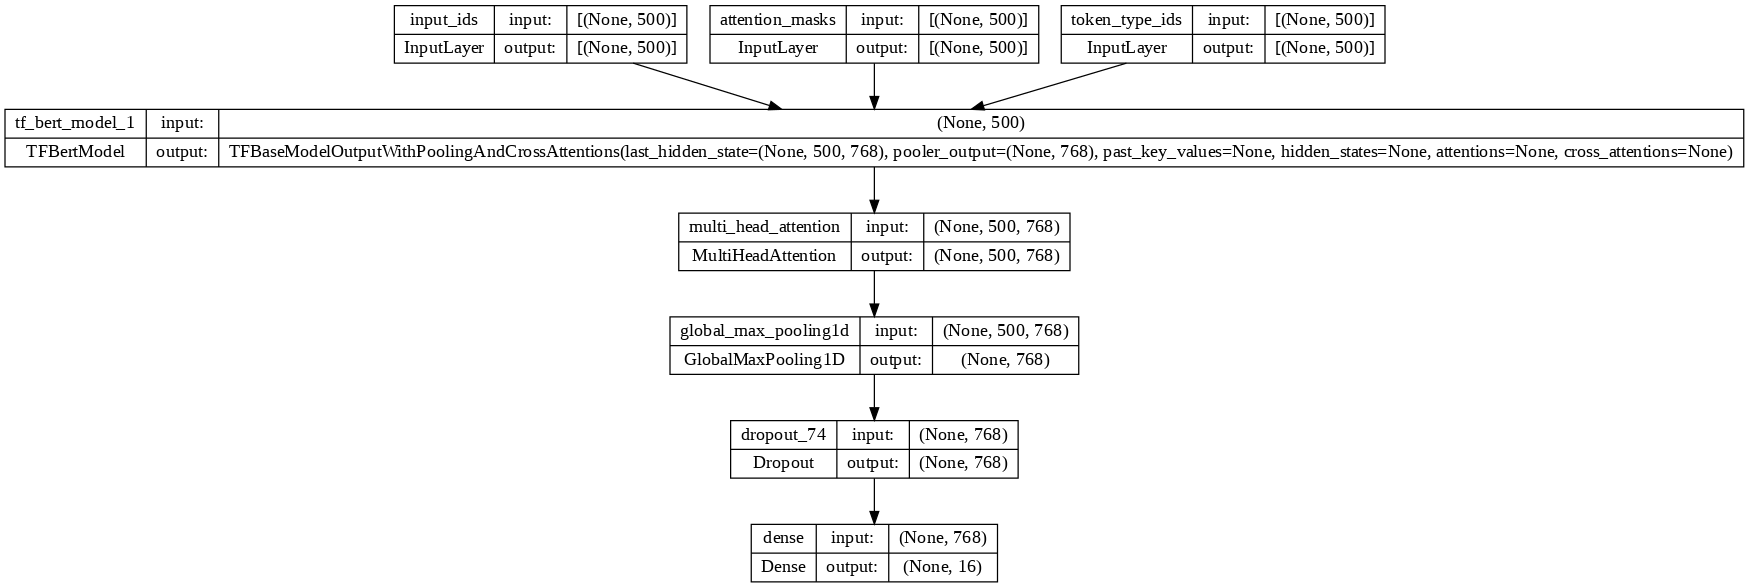

In [ ]:
keras.utils.plot_model(pooled_bert_model, show_shapes=True, dpi=90)

In [ ]:
pooled_bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 500)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 500)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 500)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

In [ ]:
nptrain_labels.shape

(60000,)

In [ ]:
npdev_labels.shape

(10000,)

In [ ]:
pooled_bert_model_history = pooled_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
                                                  nptrain_labels,   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
                                                  npdev_labels),    
                                                  batch_size=16, 
                                                  epochs=2)  

Epoch 1/2


3750/3750 [==============================] - 904s 238ms/step - loss: 4.4611 - accuracy: 0.3909 - val_loss: 4.2833 - val_accuracy: 0.0012
Epoch 2/2
3750/3750 [==============================] - 893s 238ms/step - loss: 2.0742 - accuracy: 0.3924 - val_loss: 2.9423 - val_accuracy: 0.0012


In [ ]:
score = pooled_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask], 
                                                  nptest_labels) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

313/313 [==============================] - 51s 153ms/step - loss: 5.3620 - accuracy: 7.0000e-04
Test loss: 5.361981391906738
Test accuracy: 0.000699999975040555


In [ ]:
#run predict for the first three elements in the test data set
predictions = pooled_bert_model.predict([test_encodings.input_ids[:3], test_encodings.token_type_ids[:3], test_encodings.attention_mask[:3]])

1/1 [==============================] - 3s 3s/step


In [ ]:
#run and capture all predictions from our test set using model.predict
### YOUR CODE HERE
length = len(test_encodings.input_ids)
predictions = pooled_bert_model.predict([test_encodings.input_ids[:length], test_encodings.token_type_ids[:length], test_encodings.attention_mask[:length]])
### END YOUR CODE

#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions = tf.argmax(predictions, axis=-1)
predictions

313/313 [==============================] - 47s 149ms/step


<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([12, 12, 12, ..., 12, 12, 12])>

In [ ]:
nptest_labels[1000:]

array([ 0,  0,  0, ..., 14, 14, 14])

In [ ]:
print(classification_report(nptest_labels, predictions.numpy(), target_names=valid_MBTI))

ValueError: ignored

In [ ]:
cm = tf.math.confusion_matrix(nptest_labels, predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(20,16))
sns.heatmap(
    cm, annot=True,
    xticklabels=valid_MBTI,
    yticklabels=valid_MBTI)
plt.xlabel("Predicted")
plt.ylabel("True")


In [ ]:
label_dict = {'neutral': 0, 'entailment': 1, 'contradiction': 2}

In [ ]:
def preprocess_data(sentence_pairs, label_strs, tokenizer, max_length=128):
    # With BERT tokenizer's batch_encode_plus, sentence pairs are
    # encoded together and separated by [SEP] token.
    encoded = tokenizer.batch_encode_plus(
        sentence_pairs,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors="tf"
    )

    # Extract encoded features and labels, add to corresponding lists
    input_ids = np.array(encoded["input_ids"], dtype="int32")
    attention_masks = np.array(encoded["attention_mask"], dtype="int32")
    token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

    # Convert string labels into numbered categories
    labels = np.array([label_dict[label] if label in label_dict else 0
                       for label in label_strs])
    
    return [input_ids, attention_masks, token_type_ids], labels

In [ ]:
class SNLIDataGeneratorFromFile(tf.keras.utils.Sequence):
    
    def __init__(self,
                 tokenizer,
                 n_examples,
                 data_filename,
                 max_length=128,
                 batch_size=32,
                 shuffle=True):
        
        self.tokenizer = tokenizer
        self.n_examples = n_examples
        self.data_filename = data_filename
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(1, self.n_examples+1)
        self.on_epoch_end()
    
    def __len__(self):
        # NOTE: USING REDUCED BATCHES PER EPOCH TO SPEED UP THE LIVE DEMO
        # For normal use, this line should be:
        return self.n_examples // self.batch_size
#        return 100
    
    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size

        # Indices to skip are the ones in the shuffled row_order before and
        # after the chunk we'll use for this batch
        batch_idx_skip = self.row_order[:batch_start] + self.row_order[batch_end:]
        df = pd.read_csv(self.data_filename, skiprows=batch_idx_skip)
        
        sentence_pairs = df[['sentence1', 'sentence2']].values.astype(str).tolist()
        labels = df['similarity'].values
        
        batch_data = preprocess_data(
            sentence_pairs,
            labels,
            self.tokenizer,
            self.max_length
        )

        return batch_data
    
    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))

In [ ]:
bert_model_name='bert-base-uncased'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = TFAutoModel.from_pretrained(bert_model_name)
bert_model.trainable = False

In [ ]:
train_data_generator = SNLIDataGeneratorFromFile(
    tokenizer=bert_tokenizer,
    n_examples=550152,
    data_filename=train_mbti_data
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

!ls drive/MyDrive/ISchool/MIDS/W266/2022_Fall/

In [ ]:
# CHANGE checkpoint_dir TO THE PATH IN YOUR OWN DRIVE WHERE YOU WANT TO SAVE CHECKPOINTS

checkpoint_dir = 'drive/MyDrive/ISchool/MIDS/W266/2022_Fall/model_checkpoints/'
checkpoint_filepath = checkpoint_dir + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [ ]:
model = build_snli_model(bert_model, max_length=128, hidden_dim=256)
model.summary()

In [ ]:
model.fit(train_data_generator, validation_data=dev_data, epochs=5,
          callbacks=[model_checkpoint_callback])

# **Running Our Initial Models**

We begin our analysis by performing unigram vectorization of the text field in the training and dev datasets. We attempt the use of two models - Logistical Regression and Naive Bayes. We also perform some analysis of the usefulness of a custom preprocessor for the text. For our vectorization, we have chosen TFID. 
